# K-Mean Clustering

**Overview**<br>
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

We will be using the online reatil trasnational dataset to build a RFM clustering and choose the best set of customers.

In [0]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Online+Retail.csv to Online+Retail (1).csv


In [0]:
import io
#reading Dataset
retail = pd.read_csv(io.BytesIO(uploaded['Online+Retail.csv']),  sep = ',',encoding = "ISO-8859-1",header=0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [23]:
data =pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [20]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [0]:
#Sanity Check
print(retail.shape)

retail.info()

In [0]:
retail.describe()

In [0]:
#Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [0]:
#dropping the na cells
order_wise = retail.dropna()

In [0]:
#Sanity check
order_wise.shape
#order_wise.isnull().sum()

(406829, 8)

In [0]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [0]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [0]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


#### If in the above result you get a column with name level_1, uncomment the below code and run it, else ignore it and keeping moving.

In [0]:
#monetary.drop(['level_1'], axis = 1, inplace = True)
#monetary.head()

In [0]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [0]:
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [0]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [0]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [0]:
a = recency.groupby('CustomerID')

In [0]:
a.diff.min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
12352.0    36 days 22:13:00
12353.0   204 days 19:03:00
12354.0   232 days 23:39:00
12355.0   214 days 23:01:00
12356.0    23 days 04:10:00
12357.0    33 days 20:43:00
12358.0     2 days 02:24:00
12359.0     8 days 01:29:00
12360.0    52 days 21:28:00
12361.0   287 days 22:59:00
12362.0     3 days 21:10:00
12363.0   110 days 02:32:00
12364.0     8 days 02:28:00
12365.0   291 days 22:46:00
12367.0     4 days 20:02:00
12370.0    51 days 21:59:00
12371.0    45 days 02:34:00
12372.0    72 days 00:38:00
12373.0   311 days 23:40:00
12374.0    25 days 21:13:00
12375.0     3 days 01:23:00
12377.0   315 days 21:05:00
12378.0   130 days 02:16:00
12379.0    82 days 02:41:00
12380.0    22 days 01:23:00
                 ...       
18245.0     7 days 22:02:00
18246.0    24 days 01:01:00
18248.0   114 days 06:36:00
18249.0    17 days 21:43:00
18250.0  

In [0]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [0]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


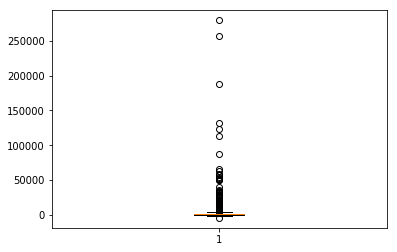

In [0]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

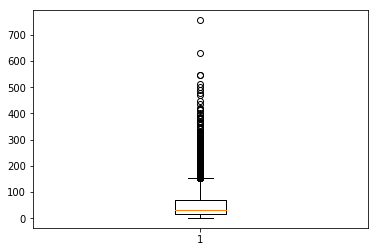

In [0]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

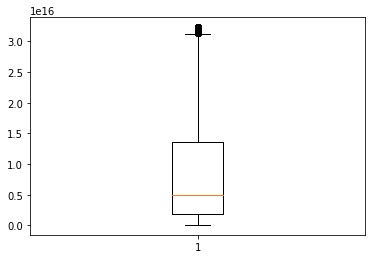

In [0]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [0]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00
5,12352.0,95,1545.41,36 days 22:13:00
6,12353.0,4,89.00,204 days 19:03:00
7,12354.0,58,1079.40,232 days 23:39:00
8,12355.0,13,459.40,214 days 23:01:00
9,12356.0,59,2811.43,23 days 04:10:00
11,12358.0,19,1168.06,2 days 02:24:00


In [0]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [0]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-0.783868,-1.065957,2.443383
1,-0.410310,1.137317,-0.193213
2,0.130704,1.088660,-0.781457
3,-0.590649,-0.656009,2.275313
4,0.414093,0.828593,-0.602883


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [0]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [0]:
hopkins(RFM_norm1)

0.960975358373087

## K-Means with some K

In [0]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [0]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

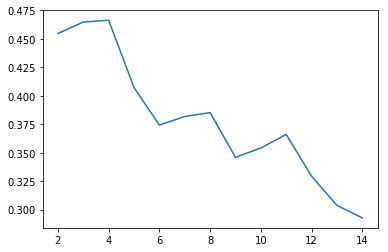

In [0]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

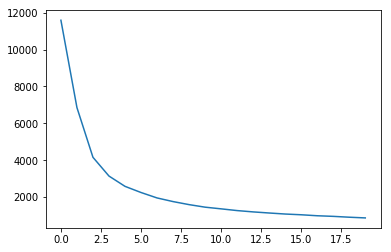

In [0]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [0]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [0]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,366.605145,23.954887,242.146079
1,1,407.495990,27.927297,52.382022
2,2,2600.225555,138.919598,36.065327
3,3,2265.429340,386.198113,23.141509
4,4,1231.063731,89.667396,42.874179


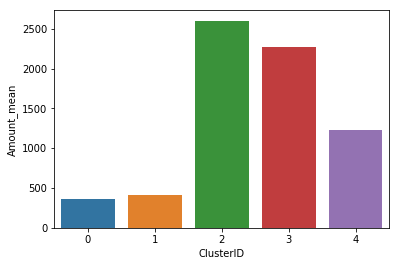

In [0]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


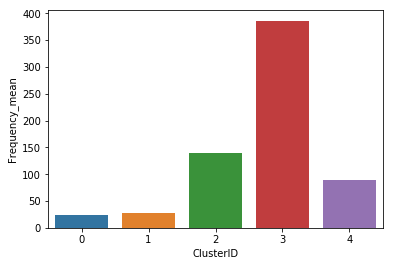

In [0]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

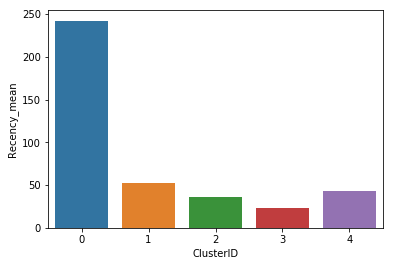

In [0]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

<hr>

## Heirarchical Clustering

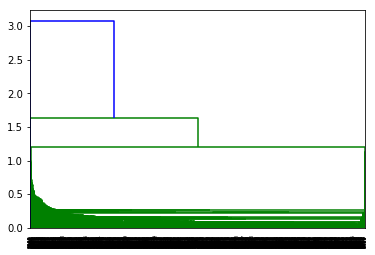

In [0]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

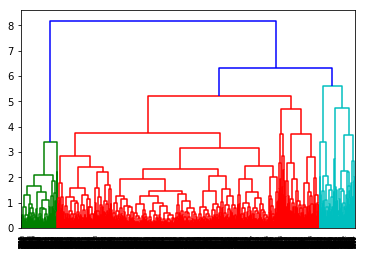

In [0]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [0]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

In [0]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [0]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,208.283568,15.052083,316.375000
1,1,1802.677713,56.529148,84.434978
2,2,868.596250,99.324074,74.069444
3,3,508.022393,28.704861,85.269097
4,4,2100.566225,123.880795,44.059603


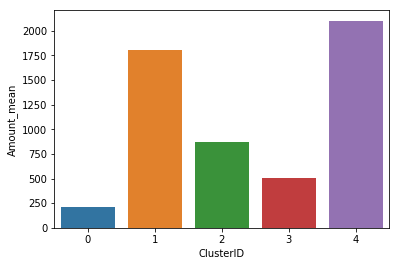

In [0]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

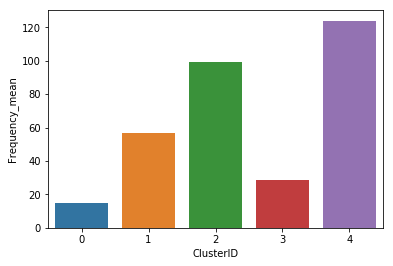

In [0]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

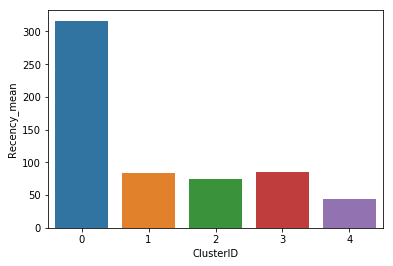

In [0]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)